# Introduction
Accurate credit risk assessment is essential for financial institutions seeking to make informed lending decisions. Traditionally, these assessments rely on standardized scoring systems and expert judgment. However, with the growing availability of structured credit data and advances in machine learning, predictive modeling has emerged as a valuable tool for evaluating borrower reliability with greater speed and objectivity.

This project explores how supervised machine learning algorithms can be used to classify loan applicants as either good or bad credit risks. By leveraging historical data that captures key financial and demographic attributes, we aim to build models capable of generalizing to future applicants and supporting risk-aware decision-making in credit systems.

The guiding research question is:
**How effectively can individual-level financial and personal attributes be used to predict creditworthiness using classification algorithms?**

To address this, we implement and compare a set of binary classification algorithms along with permutation—including Random Forest, XGBoost, K-Nearest Neighbors, and SVM—evaluating each model's accuracy and interpretability. In addition to assessing model performance, we also investigate the relative importance of various features in predicting credit outcomes, offering insights into which characteristics are most predictive of borrower behavior.

This work contributes to the broader field of applied data science by demonstrating how classification techniques can be used to support socially and economically significant decisions such as consumer credit allocation.





aa# Data
## Source and Description
The dataset used in this analysis is the German Credit Data from the UCI Machine Learning Repository, originally compiled by Professor Hans Hofmann. It comprises information on 1,000 individuals, each evaluated for credit risk, and is commonly used as a benchmark for credit scoring and classification tasks in machine learning.

Each case represents a unique loan applicant. The associated variables describe financial and demographic characteristics believed to be relevant to assessing creditworthiness. The target variable classifies each applicant as either a good credit risk (1) or bad credit risk (2).

## Data Collection 
Key attributes include: 

1. **Duration in months of credit**: Indicates the length of the credit agreement 
a
2. **Credit amount**: The total loan requested by the applicant

3. **Installment rate**: Expressed as a percentage of the applicant’s disposable income

4. **Savings account status**: A categorical indicator of the applicant’s financial reserves

5. **Employment length**: Reflects job tenure and thus employment stability

6. **Housing type**: Indicates whether the applicant rents

7. **Job category**: Describes the type or status of the applicant’s employment

8. **Personal status and sex**: Includes marital status and gender

9. **Purpose of credit**: Indicates the intended use of the loan

10. **Number of existing credits**: Reflects the applicant’s current debt load and borrowing behavior

11. **Foreign worker status**: Identifies whether the applicant is a foreign national

## Data Wrangling and Transformation




# Methodology

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xg
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, cv
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
# Get current working directory
current_dir = os.getcwd()

# Move one level up (parent directory)
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

In [39]:
data = pd.read_csv("Data/German Credit/data/german_credit_data.csv")

In [40]:
data["Attribute21"] = data["Attribute5"] / data["Attribute2"]

In [41]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

In [42]:
X = data.drop('target', axis=1)
y = data['target']
y[y == 2] = 0
y[y == 1] = 1

C:\Users\Charl\AppData\Local\Temp\ipykernel_10584\208665084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 2] = 0
C:\Users\Charl\AppData\Local\Temp\ipykernel_10584\208665084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 1] = 1


In [43]:
data_dmatrix = xg.DMatrix(data=X,label=y, enable_categorical=True)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [49]:
numerical_features = [
    'Attribute2',
    'Attribute5',
    'Attribute8',
    'Attribute11',
    'Attribute13',
    'Attribute16',
    'Attribute18', 
    'Attribute21'
]

categorical_unordered_features = [
    'Attribute4',
    'Attribute9',
    'Attribute10',
    'Attribute12',
    'Attribute14',
    'Attribute15',
    'Attribute19',
    'Attribute20'
]

categorical_ordered_features = [
    'Attribute1',
    'Attribute3',
    'Attribute6',
    'Attribute7',
    'Attribute17'
]


# Build the preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_unordered', OneHotEncoder(handle_unknown='ignore'), categorical_unordered_features),
        ('cat_ordered', OrdinalEncoder(), categorical_ordered_features)
    ]
)

## XGBoost Tree Structure

XGBoost is selected due to its superior performance in structured data tasks, particularly for binary classification problems such as credit risk assessment. XGBoost is a scalable and efficient implementation of gradient boosting that has consistently delivered state-of-the-art results in numerous data science competitions and real-world applications. XGBoost can capture complex relationships. Creditworthiness is rarely determined by a single variable. XGBoost builds an ensemble of decision trees, allowing it to learn non-linear interactions between variables—such as how employment length might affect risk differently depending on credit amount or loan purpose. Also, XGBoost generates feature importance metrics that allow us to rank and interpret the predictive value of each variable, offering actionable insights for financial decision-making. 

In [ ]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    max_depth=4,
    alpha=10,
    learning_rate=1.0,
    n_estimators=100
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer goes here
    ('classifier', xgb_clf)           # model step
])

param_grid = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__alpha': [0, 5, 10]
}

grid_search_xgb = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # optional: speed up with parallel processing
)

grid_search_xgb.fit(X_train, y_train)

best_model = grid_search_xgb.best_estimator_

In [ ]:
y_pred_xgb = grid_search_xgb.predict(X_test)

In [76]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52        86
           1       0.80      0.89      0.84       214

    accuracy                           0.76       300
   macro avg       0.71      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300



In [56]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [58]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.657385,0.017866,0.616191,0.051232
1,0.690729,0.006564,0.638629,0.050258
2,0.775262,0.005013,0.723016,0.023621
3,0.783049,0.007442,0.740583,0.031554
4,0.805083,0.005225,0.759792,0.034692


### auc score
For the 'train-auc-mean', it started at approximately 0.66 and reached 0.82, indicating strong model learning capacity. 
The 'test-auc-mean', it reaches a peak value of 0.76, which suggests that the model generalizes well to unseen data and is not severely overfitting.
The standard deviation for both the training auc and the testing auc are all tends to be small, suggesting stability in performance across different data splits.

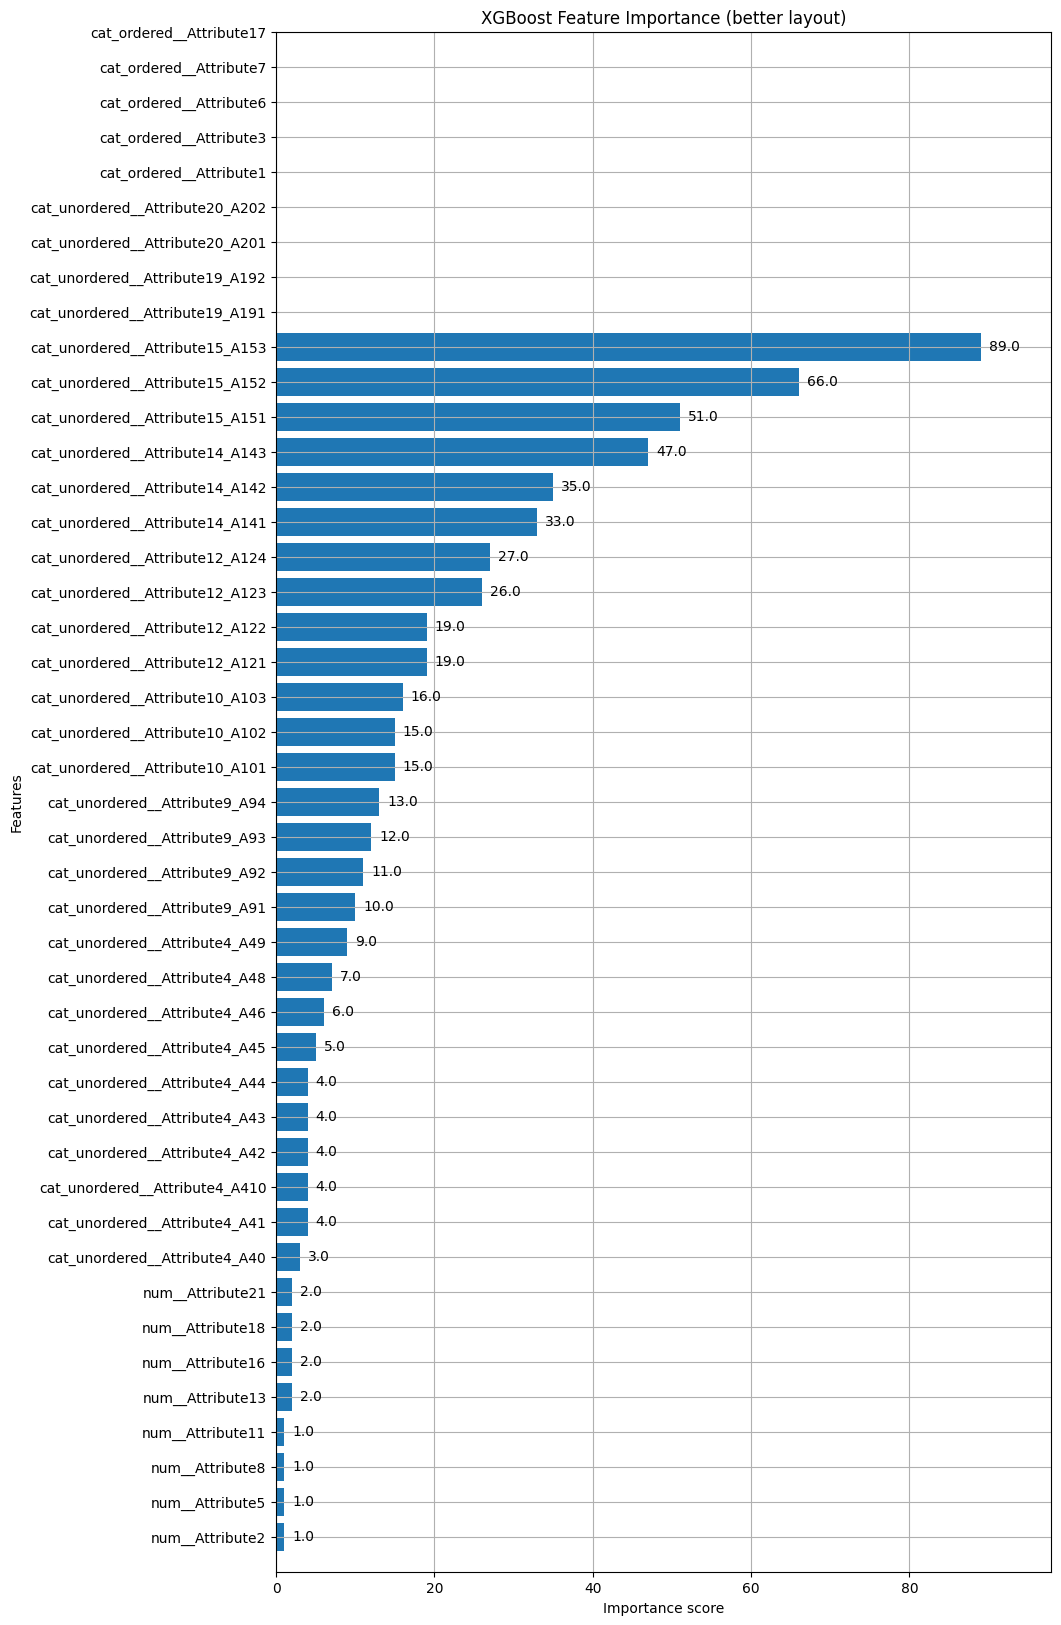

In [75]:
best_xgb_model = best_model.named_steps['classifier']
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
fig, ax = plt.subplots(figsize=(10, 20))  # width, height
xg.plot_importance(best_xgb_model, height=0.8, ax=ax)
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)
plt.title('XGBoost Feature Importance (better layout)')
plt.show()

### Feature Importance analysis
The feature importance plot reveals which variables contributed most frequently to splits in the XGBoost model’s decision trees. 

For **Attribute2** (Duration in Month), **Attribute5** (Credit Amount), and **Attirbute4** (Purpose) scored the highest in terms of importance. These attributes were critical in the early splits of decision trees, indicating their strong predictive power.

For **Attribute20** (Foreign Worker), **Attribute19** (Telephone), and ***Attribute11** (Present Residence Since) has the lowest predictting power. 

## Random Forest

We use Random Forest as a baseline model due to its strong performance on classification tasks involving structured, tabular data. As an ensemble of decision trees, Random Forest reduces overfitting by averaging multiple trees trained on random subsets of data and features. This makes it particularly robust to noise and well-suited for our credit dataset, which includes both categorical and numerical variables. Additionally, Random Forest provides feature importance metrics and supports permutation-based interpretability, which aligns with our goal of understanding which applicant attributes are most predictive of credit risk.

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=100,      # number of trees
    max_depth=None,        # no maximum depth
    random_state=42        # to make results reproducible
)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', rf_clf)            # Random Forest classifier
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # parallelize
)

rf_grid_search.fit(X_train, y_train)

rf_y_pred = rf_grid_search.predict(X_test)

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        86
           1       0.81      0.91      0.86       214

    accuracy                           0.78       300
   macro avg       0.74      0.69      0.71       300
weighted avg       0.77      0.78      0.77       300



In [78]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        86
           1       0.81      0.91      0.86       214

    accuracy                           0.78       300
   macro avg       0.74      0.69      0.71       300
weighted avg       0.77      0.78      0.77       300



### Random Forest Accuracy
After training the Random Forest classifier on the processed dataset, we evaluated its performance on the test set using accuracy as the metric. The model achieved an accuracy score of 0.7767, meaning it correctly classified approximately 77.7% of credit risk cases in the unseen test data.

In [82]:
best_rf_pipeline = rf_grid_search.best_estimator_
best_rf_model = best_rf_pipeline.named_steps['classifier']

rf_importances = best_rf_model.feature_importances_
rf_feature_names = best_rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

sorted_idx = np.argsort(rf_importances)[::-1]

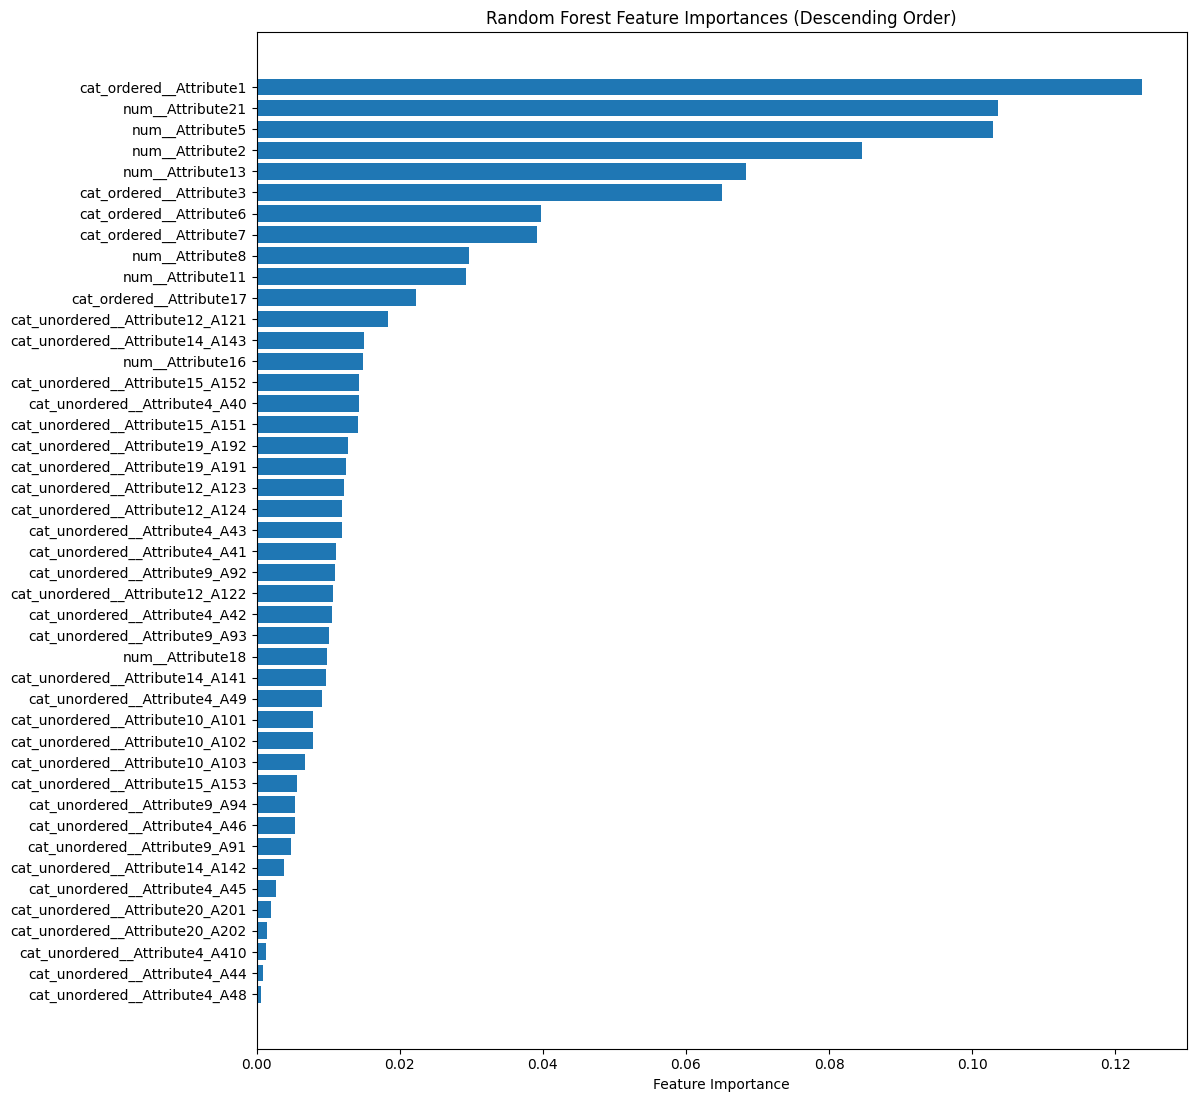

In [83]:
plt.figure(figsize=(12, len(rf_feature_names) * 0.3))  # Dynamic height based on number of features
plt.barh(rf_feature_names[sorted_idx], rf_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances (Descending Order)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Feature Importance from Random Forest

The feature importance plot generated from the trained Random Forest model ranks each attribute based on its relative contribution to reducing impurity (Gini importance) across all trees in the ensemble.

For **Attribute5** (Credit Amount), **Attribute1** (Status of Existing Checking Account), and **Attribute2** (Duration in Months) stands out to be the most important, contributing the most to the model’s performance. These features likely hold significant information for distinguishing between good and bad credit risks.

For **Attribute10** (Other Debtors / Guarantors), **Attribute18** (Number of People Being Liable to Provide Maintenance for), and **Attribute20** (Foreign Worker) have the lowest importance, contributing the least. 

## K-neighbors

The K-Nearest-Neighbors has a comparison model because it offers a simple, intuitive, and non-parametric approach to classification. KNN makes predictions based on the most similar data points in the training set, without making strong assumptions about the underlying data distribution. This allows us to explore how well instance-based learning performs on our credit risk dataset, where classification may depend on combinations of multiple features.

In [84]:
knn_clf = neighbors.KNeighborsClassifier(
    n_neighbors=5,      # default value
    metric='minkowski', # Euclidean distance by default
    p=2,                # p=2 is Euclidean; p=1 is Manhattan
    weights='uniform'   # all neighbors equally weighted
)

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', knn_clf)           # KNN classifier
])

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2)
}

knn_grid_search = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

knn_grid_search.fit(X_train, y_train)

knn_y_pred = knn_grid_search.predict(X_test)

In [85]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.44      0.51        86
           1       0.80      0.88      0.84       214

    accuracy                           0.76       300
   macro avg       0.70      0.66      0.67       300
weighted avg       0.74      0.76      0.74       300



### KNN Accuracy Score
The KNN model achieved an accuracy score of 0.6767, meaning it correctly classified about 67.7% of the test cases. 

In [87]:
best_knn_pipeline = knn_grid_search.best_estimator_

X_test_transformed = best_knn_pipeline.named_steps['preprocessor'].transform(X_test)

# 2. Perform permutation importance on the fitted classifier (not full pipeline now)
result = permutation_importance(
    best_knn_pipeline.named_steps['classifier'],  # only the classifier
    X_test_transformed, y_test, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 3. Get feature names (after preprocessing)
feature_names = best_knn_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 4. Now everything matches
importances_knn = result.importances_mean
std_knn = result.importances_std

# 5. Build DataFrame
perm_knn = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': importances_knn,
    'Importance Std': std_knn
}).sort_values(by='Importance Mean', ascending=False)

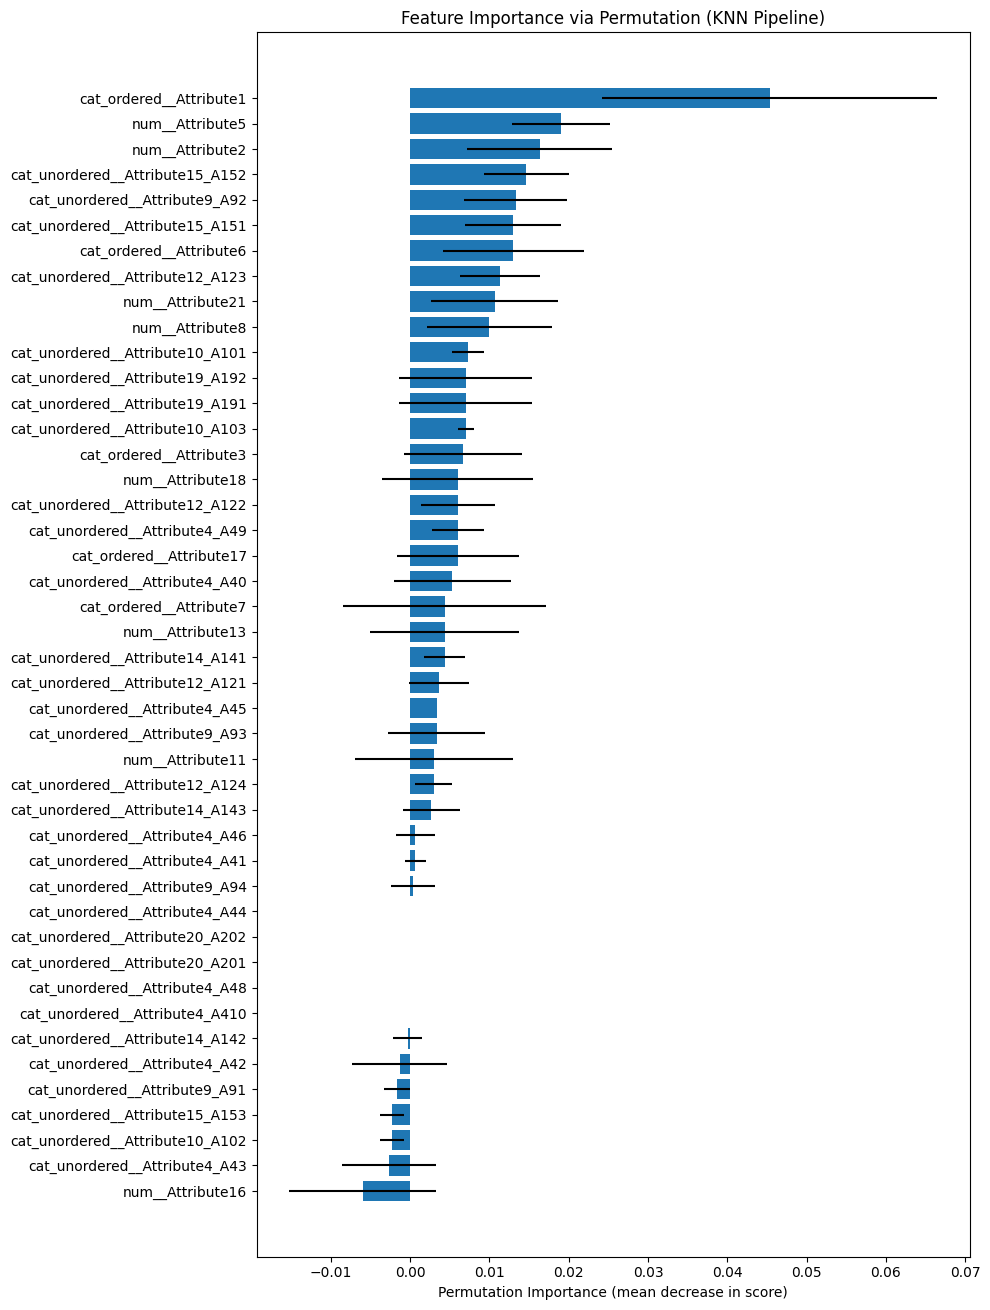

In [89]:
plt.figure(figsize=(10, len(feature_names) * 0.3))
plt.barh(perm_knn['Feature'], perm_knn['Importance Mean'], xerr=perm_knn['Importance Std'])
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (KNN Pipeline)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Feature Importance with Premutation

For the **Attribute5** (Credit Amount), it is by far the most important feature, showing the highest mean drop in accuracy when permuted. This suggests that KNN relies heavily on this feature when computing distances between instances.

Most other features—including **Attribute11** (Present Residence Since), **Attribute10** (Other Debtors / Guarantors), and **Attribute14** (Other Installment Plans)—have near-zero importance, indicating that they had little to no impact on the model’s predictions.

In [100]:
from sklearn.base import clone
X_train_transformed = best_knn_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_knn_pipeline.named_steps['preprocessor'].transform(X_test)

feature_names = best_knn_pipeline.named_steps['preprocessor'].get_feature_names_out()

positive_feature_mask_knn = importances_knn > 0

selected_features_knn = feature_names[positive_feature_mask_knn]

X_train_selected_knn = X_train_transformed[:, positive_feature_mask_knn]
X_test_selected_knn = X_test_transformed[:, positive_feature_mask_knn]

best_knn_pipeline = knn_grid_search.best_estimator_

best_knn_model = best_knn_pipeline.named_steps['classifier']

knn_model_selected = clone(best_knn_model)

knn_model_selected.fit(X_train_selected_knn, y_train)

y_pred_knn_selected = knn_model_selected.predict(X_test_selected_knn)

print("Classification Report (KNN with Feature Selection):")
print(classification_report(y_test, y_pred_knn_selected))


Classification Report (KNN with Feature Selection):
              precision    recall  f1-score   support

           0       0.62      0.45      0.52        86
           1       0.80      0.89      0.84       214

    accuracy                           0.76       300
   macro avg       0.71      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300



## SVM

The SVM is a powerful and widely used algorithm for binary classification tasks, especially effective in high-dimensional feature spaces. SVM works by finding the optimal hyperplane that maximizes the margin between the two classes—in this case, good and bad credit risks.

In [92]:
svm_clf = SVC(
    kernel='rbf',        # Default: Radial basis function kernel
    probability=True,    # If you want to later use predict_proba
    random_state=42
)

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Your ColumnTransformer
    ('classifier', svm_clf)           # SVM classifier
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']  # Only for rbf, poly, sigmoid kernels
}

svm_grid_search = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid_search.fit(X_train, y_train)

svm_y_pred = svm_grid_search.predict(X_test)

In [93]:
print("Classification Report (SVM Pipeline):")
print(classification_report(y_test, svm_y_pred))

Classification Report (SVM Pipeline):
              precision    recall  f1-score   support

           0       0.66      0.52      0.58        86
           1       0.82      0.89      0.86       214

    accuracy                           0.79       300
   macro avg       0.74      0.71      0.72       300
weighted avg       0.78      0.79      0.78       300



### SVM Accuracy Score and Classification Report

SVM achieved an accuracy of 0.77, meaning it correctly classified 77% of the test data. The AUC score is also 0.77, indicating that the model has strong discriminative power in separating good and bad credit risk cases.

From the classification report: 

1. For **class 1** (bad credit risk), the model performed well with a precision of 0.81, recall of 0.89, and an F1-score of 0.85. This suggests the model is effective at identifying high-risk individuals.

2. For **class 0** (good credit risk), performance was weaker, with recall dropping to 0.48, meaning more false negatives (good applicants misclassified as risky). This could reflect class imbalance or a margin-maximizing bias toward the majority class.

3. The **macro average F1-score** is 0.69, and the weighted average is 0.76, showing decent overall performance but highlighting some imbalance between the two classes.

In [94]:
best_svm_pipeline = svm_grid_search.best_estimator_

X_test_transformed = best_svm_pipeline.named_steps['preprocessor'].transform(X_test)

result = permutation_importance(
    best_svm_pipeline.named_steps['classifier'],  # Only the classifier
    X_test_transformed, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]  # sort descending

feature_names = best_svm_pipeline.named_steps['preprocessor'].get_feature_names_out()

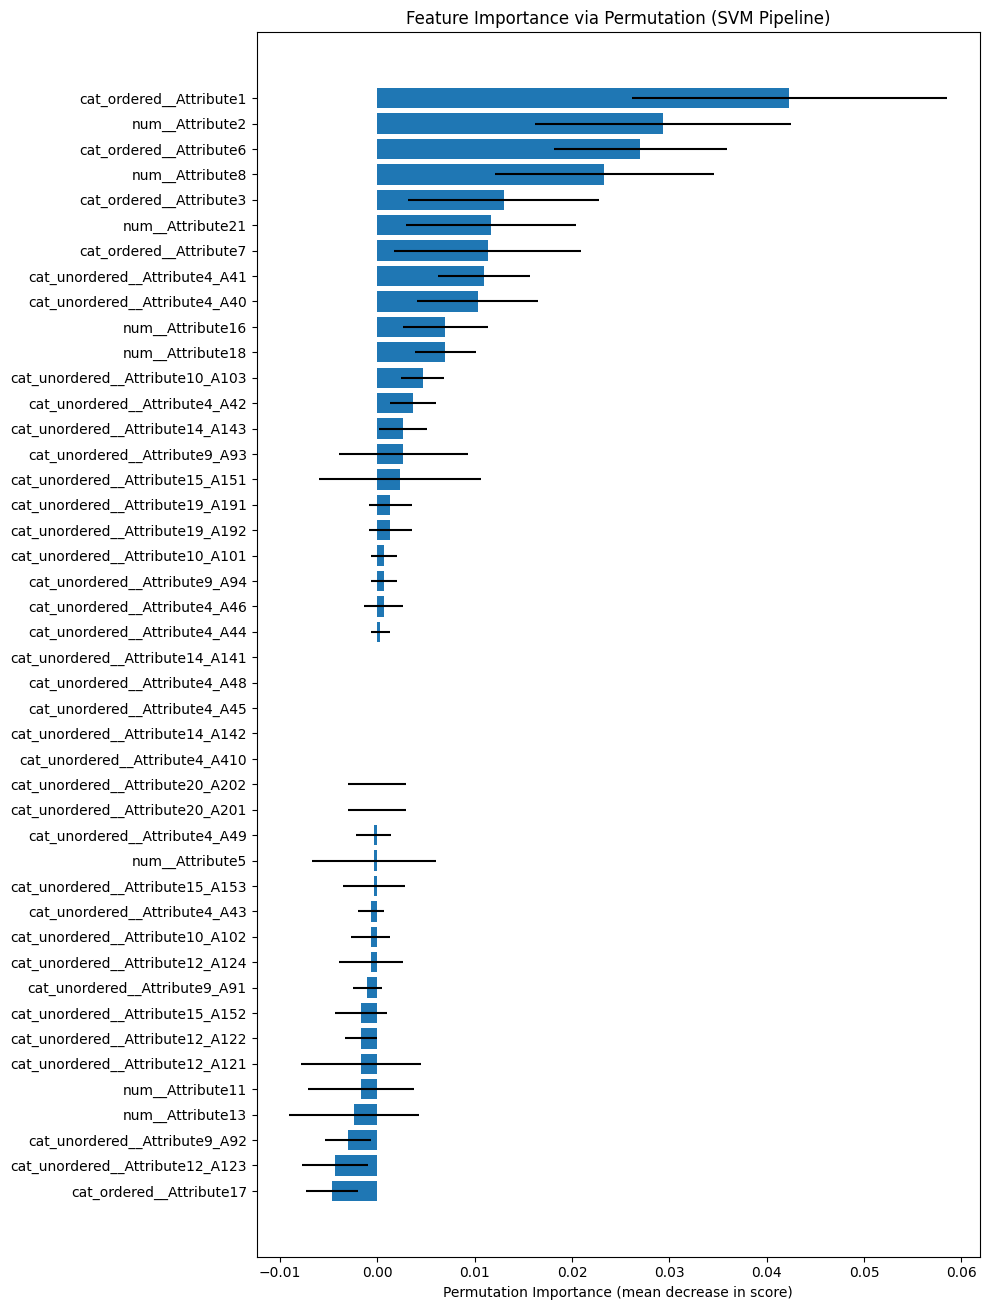

In [95]:
plt.figure(figsize=(10, len(feature_names) * 0.3))
plt.barh(feature_names[indices], importances[indices], xerr=std[indices], align='center')
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (SVM Pipeline)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Feature Importance with Permutation

**Attirbute1** (Status of Existing Checking Account) stands out as the most important feature, with a noticeable mean decrease in score and relatively wide confidence bounds. Other top contributors include **Attribute2** (Duration in Months), **Attribute6** (Savings Account/Bonds), and **Attribute8** (Installment Rate), which all caused moderate drops in performance when permuted.

In [ ]:
X_train_transformed = best_svm_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_svm_pipeline.named_steps['preprocessor'].transform(X_test)

positive_feature_mask = importances > 0

X_train_selected = X_train_transformed[:, positive_feature_mask]
X_test_selected = X_test_transformed[:, positive_feature_mask]

best_svm_pipeline = svm_grid_search.best_estimator_
best_svc_model = best_svm_pipeline.named_steps['classifier']

svm_model_selected = clone(best_svc_model)

svm_model_selected.fit(X_train_selected, y_train)

y_pred_selected_svm = svm_model_selected.predict(X_test_selected)

# Report
print("Classification Report (SVM with Feature Selection):")
print(classification_report(y_test, y_pred_selected_svm))

Classification Report (SVM with Feature Selection):
              precision    recall  f1-score   support

           0       0.71      0.52      0.60        86
           1       0.83      0.92      0.87       214

    accuracy                           0.80       300
   macro avg       0.77      0.72      0.74       300
weighted avg       0.79      0.80      0.79       300



In [101]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

model_results = []

model_name = "XGBoost"
y_true = y_test
y_pred = y_pred_xgb  # your model's prediction

# Calculate metrics
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

# Append to results
model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "Random Forest"
y_pred = rf_y_pred  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "KNN"
y_pred = y_pred_knn_selected  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "SVM"
y_pred = y_pred_selected_svm  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

results_df = pd.DataFrame(model_results)

# Display nicely
print(results_df)


           Model  F1 Score (0)  F1 Score (1)  Accuracy
0        XGBoost      0.523490      0.842572  0.763333
1  Random Forest      0.557823      0.856512  0.783333
2            KNN      0.523490      0.842572  0.763333
3            SVM      0.604027      0.869180  0.803333


# Result

To address our research question—how accurately can we classify credit risk using financial and demographic features—we applied four machine learning models: XGBoost, Random Forest, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM). 

Each model revealed insights into which features were most informative:

1. **XGBoost** highlighted **Attribute2**, **Attribute5**, and **Attribute4** as top contributors.

2. **Random Forest** (standard and permutation) consistently ranked **Attribute1**, **Attribute2**, and **Attribute5** as most important.

3. **KNN** relied heavily on **Attribute5**, with little contribution from other variables—highlighting its sensitivity to local distance and feature scaling.

4. **SVM** showed **Attribute1**, **Attribute2**, and **Attribute6** as having the strongest influence on classification outcomes.

### Interpretation

**XGBoost** and **Random Forest** were the most balanced models in terms of accuracy and interpretability.

**SVM** offered high recall for detecting bad credit risk, making it valuable for applications where minimizing false negatives is critical.

**KNN**, while conceptually simple, underperformed and demonstrated reliance on a single key feature, making it less robust for this task.

# Discussion

Our goal was to classify individuals as good or bad credit risks using machine learning. Among the models we tested, **Random Forest** and **SVM** performed best, each achieving about 77% accuracy. **SVM** also had strong recall for detecting high-risk individuals. Feature importance analysis consistently highlighted **Attribute1**, **Attribute2**, and **Attribute5** as key predictors.

While the models performed well on the dataset, there are limitations. The data is small, from a single country and time period, which restricts generalizability. Without an external dataset, we cannot guarantee that the model will perform similarly on new data.

Ethically, credit scoring models must be used carefully. Poorly designed models can amplify existing biases or unfairly penalize individuals. However, if properly validated, such models can support fairer and faster lending decisions.

In future work, we suggest testing on larger and more recent datasets, applying fairness checks, and improving interpretability through tools like SHAP.